## Gradient Boosting for Prediction and Inference

### Lesson 5
In this notebook we will put together everything we have learned as we explore a new dataset and build a new model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import catboost as cb
import structureboost as stb
import lightgbm as lgbm
import ml_insights as mli

from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 999

## MIMIC ICU data set

- This is a data set of patients in the ICU.  We have their measured lab values and vital signs, as well as an indicator of whether or not the patient died during the hospital stay.
- This is a very good example where tree-based methods are strongly preferable to Logistic Regression.  Most of the features do not have *monotonic* relationships to the target value.
- We will do a classification model, where we try to predict the probability of death given the feature values.  As we will see

In [2]:
!ls data

Ames_Housing_Data.tsv   games.csv               lab_vital_icu_table.csv


In [3]:
df_icu = pd.read_csv('data/lab_vital_icu_table.csv')
df_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59726 entries, 0 to 59725
Data columns (total 79 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            59726 non-null  int64  
 1   hadm_id               59726 non-null  int64  
 2   icustay_id            59726 non-null  int64  
 3   aniongap_min          52706 non-null  float64
 4   aniongap_max          52706 non-null  float64
 5   albumin_min           19066 non-null  float64
 6   albumin_max           19066 non-null  float64
 7   bicarbonate_min       53429 non-null  float64
 8   bicarbonate_max       53429 non-null  float64
 9   bilirubin_min         25405 non-null  float64
 10  bilirubin_max         25405 non-null  float64
 11  creatinine_min        52185 non-null  float64
 12  creatinine_max        52185 non-null  float64
 13  chloride_min          53668 non-null  float64
 14  chloride_max          53668 non-null  float64
 15  hematocrit_min     

In [4]:
df_icu.head()

subject_id  hadm_id  icustay_id  aniongap_min  aniongap_max  albumin_min  \
0           9   150750      220597          13.0          13.0          NaN   
1          13   143045      263738          10.0          14.0          3.9   
2          20   157681      264490          12.0          12.0          NaN   
3          28   162569      225559          13.0          13.0          NaN   
4          37   188670      213503           9.0          10.0          NaN   

   albumin_max  bicarbonate_min  bicarbonate_max  bilirubin_min  \
0          NaN             26.0             30.0            0.4   
1          3.9             23.0             24.0            0.4   
2          NaN             21.0             21.0            NaN   
3          NaN             23.0             23.0            NaN   
4          NaN             33.0             35.0            NaN   

   bilirubin_max  creatinine_min  creatinine_max  chloride_min  chloride_max  \
0            0.4             1.2             1.4         100.0         103.0   
1            0.4             0.5             0.8         106.0         116.0   
2            NaN             0.8             0.8         108.0         108.0   
3            NaN             0.9             1.0         109.0         112.0   
4            NaN             0.8             1.0         100.0         103.0   

   hematocrit_min  hematocrit_max  hemoglobin_min  hemoglobin_max  \
0            37.4            45.2            12.9            15.4   
1            24.0            35.6             7.9            12.3   
2            26.0            35.0             8.5            11.8   
3            26.0            41.0             8.6            13.6   
4            28.9            33.9             9.5            10.3   

   lactate_min  lactate_max  platelet_min  platelet_max  potassium_min  \
0          1.9          2.7         249.0         258.0            2.8   
1          NaN          NaN         115.0         216.0            3.0   
2          NaN          NaN         111.0         132.0            3.6   
3          NaN          NaN         137.0         150.0            3.8   
4          NaN          NaN         263.0         310.0            3.8   

   potassium_max  ptt_min  ptt_max  inr_min  inr_max  pt_min  pt_max  \
0            3.0     21.7     21.7      1.1      1.1    12.7    12.7   
1            5.3     30.8     44.1      1.2      1.8    13.3    16.5   
2            4.6     31.3     34.2      1.3      1.6    14.1    15.7   
3            5.2     31.8     32.0      1.1      1.4    13.0    15.1   
4            4.0     24.1     24.6      1.1      1.2    13.1    13.3   

   sodium_min  sodium_max  bun_min  bun_max  wbc_min  wbc_max  subject_id.1  \
0       136.0       140.0     16.0     17.0      7.5     13.7             9   
1       137.0       140.0     13.0     18.0     16.6     19.3            13   
2       137.0       143.0     18.0     18.0     17.5     17.5            20   
3       136.0       141.0     13.0     17.0      6.9      6.9            28   
4       139.0       143.0     25.0     37.0     10.4     13.9            37   

   hadm_id.1  icustay_id.1 gender            admittime            dischtime  \
0     150750        220597      M  2149-11-09 13:06:00  2149-11-14 10:15:00   
1     143045        263738      F  2167-01-08 18:43:00  2167-01-15 15:15:00   
2     157681        264490      F  2183-04-28 09:45:00  2183-05-03 14:45:00   
3     162569        225559      M  2177-09-01 07:15:00  2177-09-06 16:00:00   
4     188670        213503      M  2183-08-21 16:48:00  2183-08-26 18:54:00   

   los_hospital      age              ethnicity admission_type  \
0           5.0  41.7887  UNKNOWN/NOT SPECIFIED      EMERGENCY   
1           7.0  39.8640                  WHITE      EMERGENCY   
2           5.0  75.8757                  WHITE       ELECTIVE   
3           5.0  74.3836                  WHITE       ELECTIVE   
4           5.0  68.9269                  WHITE      EMERGENCY   

   h

## Notes on the data
- There are a lot of missing values.  This indicates that the patient was not measured for that particular value.  In many (most?) domains, imputation is a bad strategy, since the fact that the variable is missing is informative in itself.  This is an example of where the modern boosting approaches shine
- 

In [5]:
feat_1 = ['sysbp_min','sysbp_max',
       'bun_min', 'bun_max', 'wbc_min', 
        'wbc_max', 'hematocrit_min', 'hematocrit_max',
         'tempc_min', 'tempc_max', 'spo2_min', 'spo2_max',
         'lactate_min', 'lactate_max']
target_val = 'hospital_expire_flag'

In [6]:
# Get the baseline probability of death
df_icu.hospital_expire_flag.mean()

0.10874660951679335

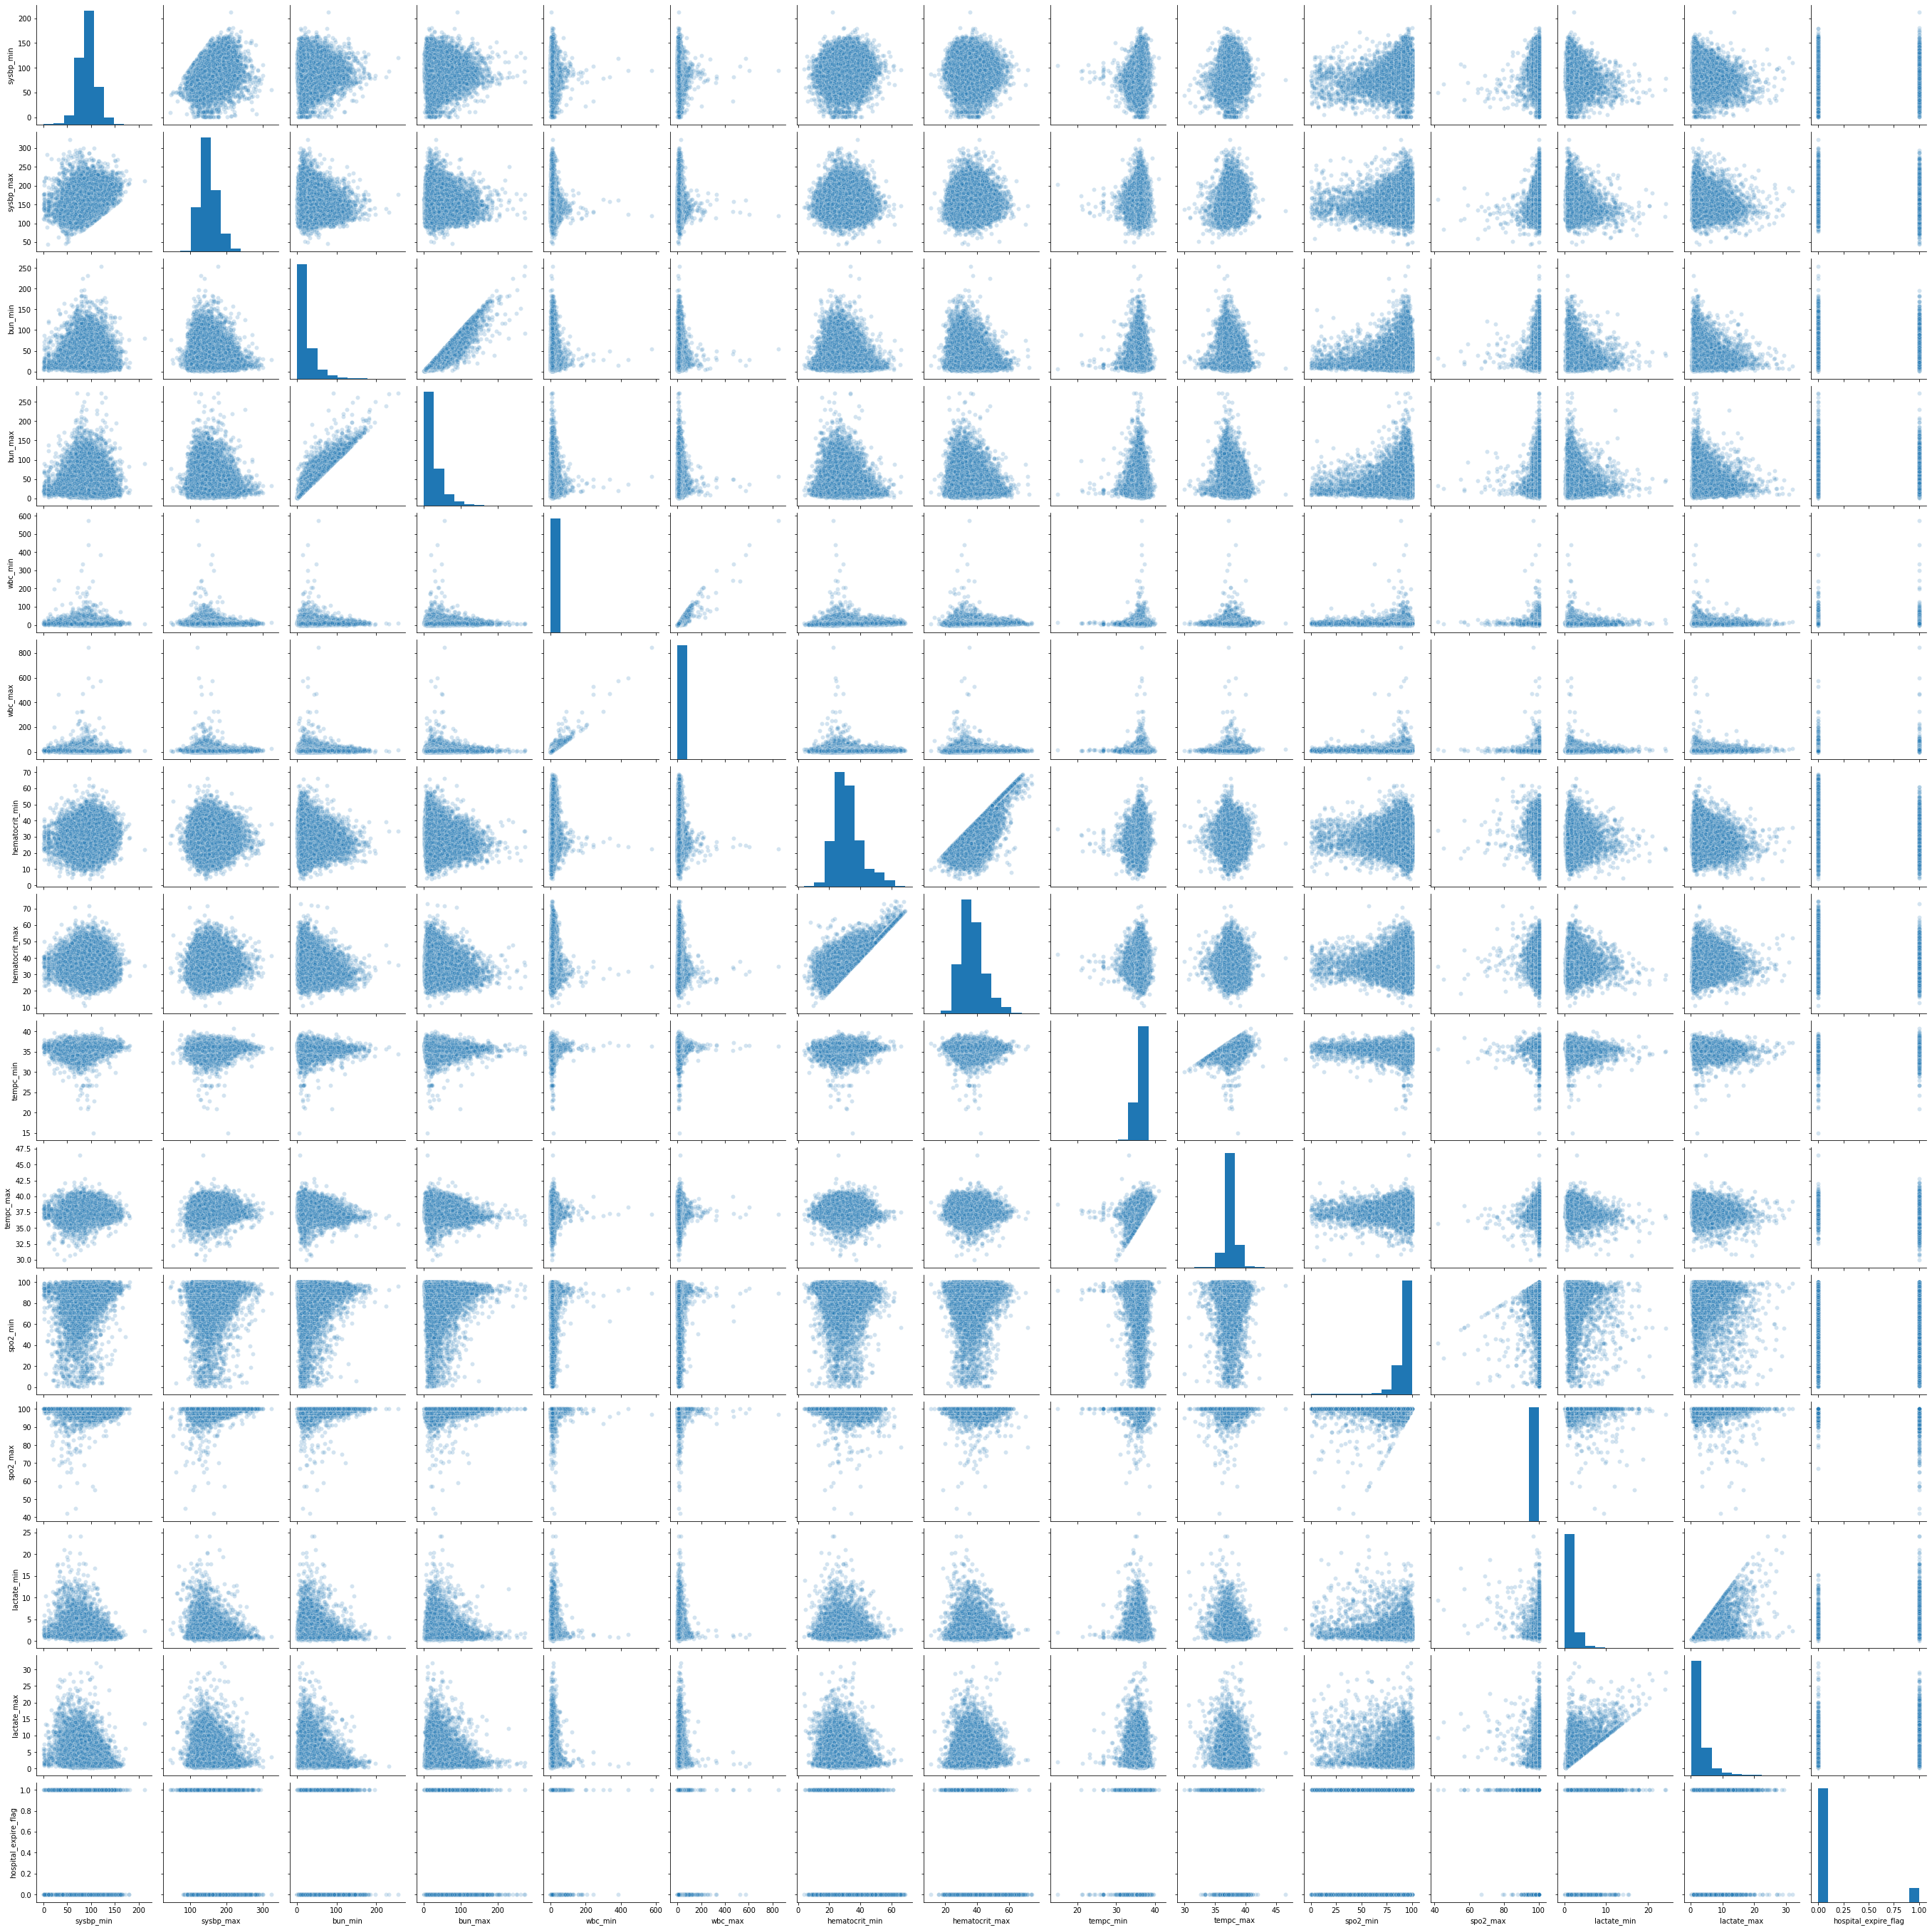

In [7]:
import seaborn as sns
sns.pairplot(df_icu.loc[:,feat_1+[target_val]], plot_kws={'alpha':.2})

### Visualizing Marginal Relationships in Classification
- As you can see above, the `pairplot` is not as effective at visualizing the relationship of the features to the target when the target is binary.
- The `histogram_pair` function in ml_insights was designed to help with this.  We will use it now.

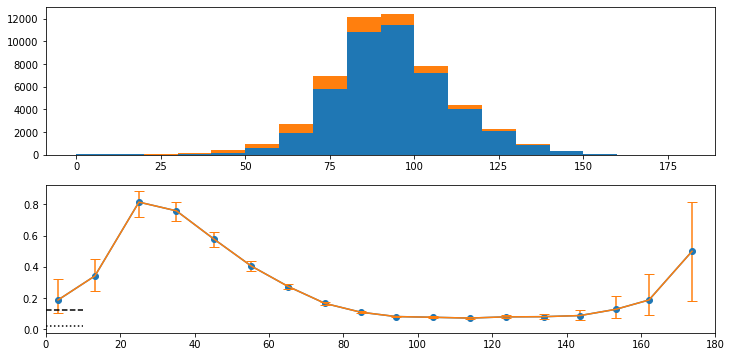

In [8]:
binvec = np.linspace(0,180, 19)
mli.histogram_pair(df_icu.sysbp_min, df_icu.hospital_expire_flag, bins=binvec);

### The `histogram_pair` plotting tool
This plot works as follows:
- The top plot is a histogram of the feature values using the bin values you provide (often takes some trial and error to good bins)
- The two colors indicate the proportion of 0s and 1s in that bin
- The bottom chart plots the `marginal probability` (i.e. percentage of 1s) of cases where the feature values fall into each bin
- The error bars indicate the 95% CI (using a Beta distribution).  When there is more data in the bin, the error bars are smaller
- The dotted (dashed) line at the left indicate the probabilities for when the variable is NA (not NA)

### Comprehension Question

- What do you notice about the dotted line?  What does that suggest as to the viability of an imputation strategy?

## Exercise
- Make histogram pairs for the features ending in 'min'

In [9]:
#binvec = np.linspace(...)
#mli.histogram_pair(..., bins=binvec);

In [10]:
X = df_icu.drop('hospital_expire_flag', axis=1)  # everything except 
y = df_icu.hospital_expire_flag 

In [11]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X,y,test_size = .2, random_state=0)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid,y_train_valid,
                                                      test_size = 3000, random_state=0)

In [13]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape

((44780, 78), (3000, 78), (11946, 78), (44780,))

In [14]:
X_train_1 = X_train.loc[:,feat_1]
X_valid_1 = X_valid.loc[:,feat_1]
X_test_1 = X_test.loc[:,feat_1]

In [15]:
X_train_1.shape, X_valid_1.shape, X_test_1.shape

((44780, 14), (3000, 14), (11946, 14))

### Warning
By default, XGBoost uses accuracy as the eval_metric.  This is a terrible choice.  You should always use logloss.

In [16]:
xgb1 = xgb.XGBClassifier(max_depth=3, learning_rate=.01, n_estimators=10000)

In [17]:
xgb1.fit(X_train_1, y_train, eval_set=[(X_valid_1, y_valid)], 
         early_stopping_rounds=20, eval_metric='logloss')

[0]	validation_0-logloss:0.68648
Will train until validation_0-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.67994
[2]	validation_0-logloss:0.67352
[3]	validation_0-logloss:0.66725
[4]	validation_0-logloss:0.66108
[5]	validation_0-logloss:0.65507
[6]	validation_0-logloss:0.64913
[7]	validation_0-logloss:0.64331
[8]	validation_0-logloss:0.63762
[9]	validation_0-logloss:0.63204
[10]	validation_0-logloss:0.62654
[11]	validation_0-logloss:0.62116
[12]	validation_0-logloss:0.61586
[13]	validation_0-logloss:0.61067
[14]	validation_0-logloss:0.60557
[15]	validation_0-logloss:0.60055
[16]	validation_0-logloss:0.59563
[17]	validation_0-logloss:0.59080
[18]	validation_0-logloss:0.58604
[19]	validation_0-logloss:0.58138
[20]	validation_0-logloss:0.57681
[21]	validation_0-logloss:0.57229
[22]	validation_0-logloss:0.56789
[23]	validation_0-logloss:0.56354
[24]	validation_0-logloss:0.55928
[25]	validation_0-logloss:0.55508
[26]	validation_0-logloss:0.55093
[27]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
xgb1_prob_preds = xgb1.predict_proba(X_test_1)[:,1]

In [19]:
log_loss(y_test, xgb1_prob_preds), roc_auc_score(y_test, xgb1_prob_preds)

(0.2513777292771051, 0.841399059332088)

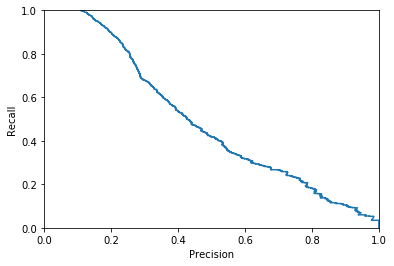

In [20]:
mli.plot_pr_curve(y_test, xgb1_prob_preds)
#mli.plot_pr_curves([y_test,y_test],[old_probs, xgb1_prob_preds])

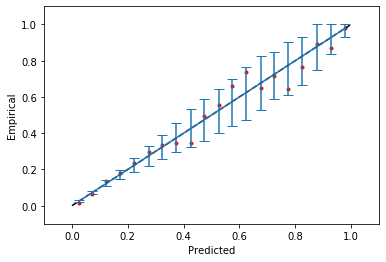

In [21]:
mli.plot_reliability_diagram(y_test, xgb1_prob_preds, marker='.');

## Exercise
- Repeat the cells above using only 100 trees (rather than 10000) to see how the reliability diagram would look from a poorly calibrated model

In [22]:
rd = mli.get_range_dict(X_train_1)
test_pts = X_test_1.sample(5)
rd['tempc_min'] = np.arange(30,43)
rd['tempc_max'] = np.arange(30,43)
rd['spo2_min'] = np.linspace(60,100,41)
rd['spo2_max'] = np.linspace(60,100,41)
rd['wbc_min'] = np.linspace(0,200,201)
rd['wbc_max'] = np.linspace(0,200,201)

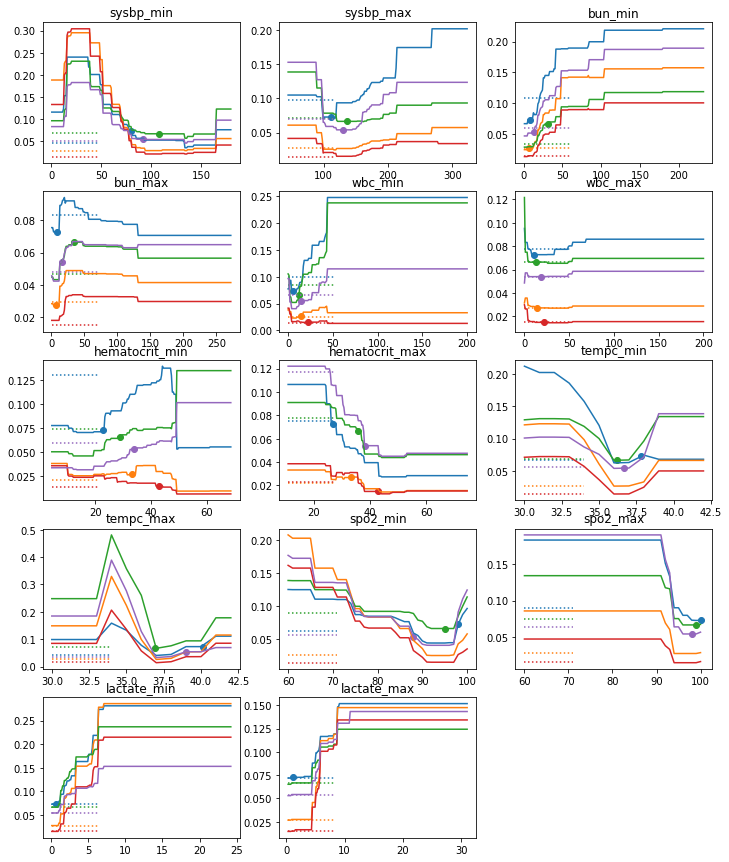

In [23]:
mli.ice_plot(xgb1, test_pts, X_test_1.columns, rd, show_nan=True)

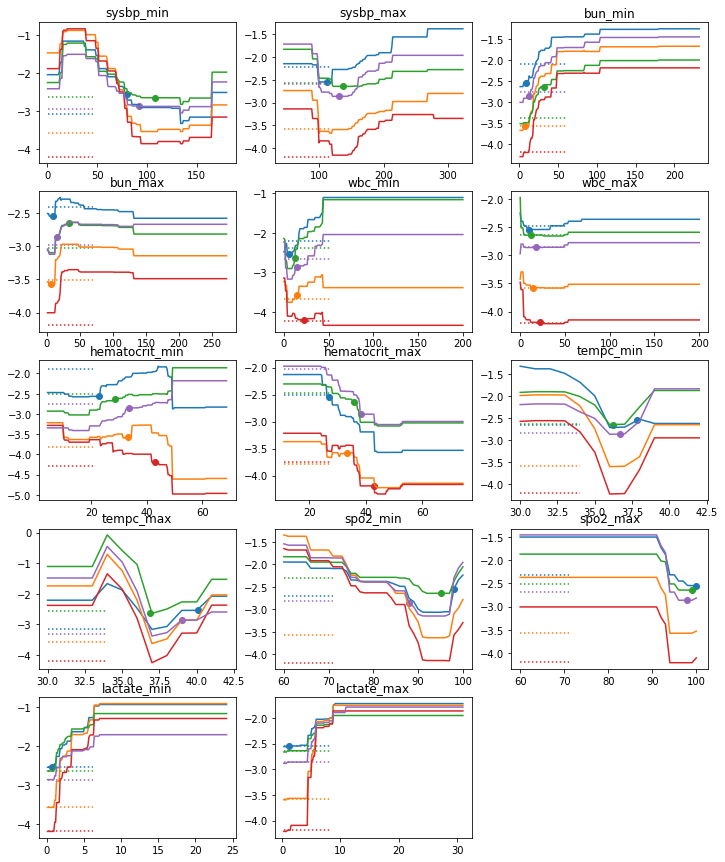

In [24]:
mli.ice_plot(xgb1, test_pts, X_test_1.columns, rd, y_scaling='logit', show_nan=True)

## Exercise 1
- Now's your chance to apply everything we've learned
- Pick a boosting package and build a model!
- Use early stopping on the *validation set*
- Tune the max_depth
- Fiddle with other parameters
- Check your performance and the ICE-plots to see how they change
- Get the SHAP values and analyze them

## Exercise 2
- Add some more variables and improve the model!
